<a href="https://colab.research.google.com/github/berthine/AMMI_git/blob/master/eng_french_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Implementation of NMT using Keras**

This Notebook as been inspired by Nagesh Singh Chauhan
Nagesh Singh Chauhan.

Machine translation is a subfield of computational linguistics that is focused on the task of automatically converting source text in one language to text in another language.

In machine translation, the input already consists of a series of symbols in some language, and the computer program must convert this into a series of symbols in a different language.

Neural machine translation (NMT) is a proposition to machine translation that uses an artificial neural network to predict the probability of a sequence of words, typically modeling whole sentences in a single integrated model.

The dataset  contains English sentences and their French translations. On each line, the text file contains an English sentence and its French translation, separated by a tab.


Let’s first import the required libraries:


In [1]:
#Import Libraries
import os, sys
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

#Values for different parameters:
BATCH_SIZE = 64
EPOCHS = 20
LSTM_NODES =256
NUM_SENTENCES = 20000
MAX_SENTENCE_LENGTH = 50
MAX_NUM_WORDS = 20000
EMBEDDING_SIZE = 200

## Let’s go ahead and split each line into input text and target text.

In the scriptbellow we created three lists input_sentences[], output_sentences[], and output_sentences_inputs[]. Next, in the for loop the fra.txt file is read one line at a time. Each line is split into two substrings at the position where the tab occurs. The left substring (the English sentence) is inserted into the input_sentences[] list. The substring to the right of the tab is the corresponding translated French sentence.

Here, the <eos> token, which denotes the end-of-sentence is prefixed to the translated sentence. Similarly, the <sos> token, which denotes for "start of the sentence", is concatenated at the start of the translated sentence.

In [6]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []

count = 0
for line in open('fra.txt', encoding="utf-8"):
    count += 1
    if count > NUM_SENTENCES:
        break
    if '\t' not in line:
        continue
    input_sentence = line.rstrip().split('\t')[0]
    output = line.rstrip().split('\t')[1]

    output_sentence = output + ' <eos>'
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Number of sample input:", len(input_sentences))
print("Number of sample output:", len(output_sentences))
print("Number of sample output input:", len(output_sentences_inputs))

Number of sample input: 20000
Number of sample output: 20000
Number of sample output input: 20000


## Let us also print a random sentence from the lists:

In [7]:
print("English sentence: ",input_sentences[180])
print("French translation: ",output_sentences[180])

print("English sentence: ",input_sentences[280])
print("French translation: ",output_sentences[280])

English sentence:  I'm shy.
French translation:  Je suis timide. <eos>
English sentence:  Go ahead!
French translation:  Avance ! <eos>


## Tokenization and Padding

The next step is tokenizing the original and translated sentences and applying padding to the sentences that are longer or shorter than a certain length, which in case of inputs will be the length of the longest input sentence. And for the output, this will be the length of the longest sentence in the output.

But before we do that, let’s visualize the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and French, respectively.

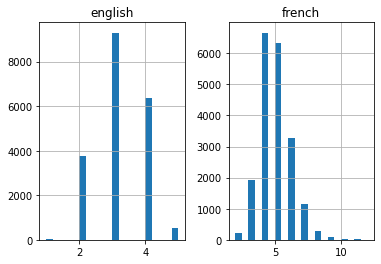

In [8]:
eng_len = []
fren_len = []

# populate the lists with sentence lengths
for i in input_sentences:
      eng_len.append(len(i.split()))

for i in output_sentences:
      fren_len.append(len(i.split()))

length_df = pd.DataFrame({'english':eng_len, 'french':fren_len})

length_df.hist(bins = 20)
plt.show()



The histogram above shows the maximum length of the French sentences is 12 and that of the English sentence is 6.

Next, vectorize our text data by using **Keras’s Tokenizer() class**. It will turn our sentences into sequences of integers. We can then pad those sequences with zeros to make all the sequences of the same length.

In [9]:
#tokenize the input sentences(input language) 
input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)
print(input_integer_seq)

word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

[[20], [853], [853], [190], [190], [67], [2442], [610], [73], [774], [62], [62], [62], [111], [111], [20, 43], [20, 43], [20, 43], [854], [854], [1, 66], [1, 76], [1, 227], [1, 227], [1, 227], [775, 29], [951], [951], [1211], [1211], [1211], [1211], [48, 39], [20, 60], [20, 60], [20, 60], [54, 4], [54, 4], [54, 4], [54, 4], [54, 4], [1781, 38], [1781, 38], [513, 12], [513, 12], [1, 415], [1, 415], [1, 2443], [1, 61], [1, 140], [1, 140], [1, 403], [1, 100], [1, 387], [6, 1782], [6, 156], [6, 156], [514], [29, 204], [29, 204], [29, 204], [29, 204], [29, 204], [29, 204], [29, 204], [29, 204], [29, 204], [154], [154], [154], [337], [337], [13, 76], [13, 227], [13, 227], [13, 227], [13, 227], [159, 7], [338], [27, 339], [27, 339], [27, 339], [27, 238], [27, 404], [27, 404], [27, 404], [27, 404], [27, 404], [27, 404], [27, 461], [27, 106], [27, 106], [27, 106], [27, 106], [27, 106], [27, 106], [855, 4], [161, 12], [161, 12], [161, 57], [161, 57], [49, 38], [49, 38], [49, 38], [49, 38], [49, 

Let the same for the output sentences:

In [10]:
#tokenize the output sentences(Output language)
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)
print(output_input_integer_seq)

word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

[[2, 64, 5], [2, 1052, 5], [2, 4547], [2, 4548], [2, 4549], [2, 36, 4], [2, 30, 4550], [2, 74, 725, 5], [2, 20, 4551], [2, 4552], [2, 30, 2709], [2, 4553], [2, 2013, 5], [2, 314, 5], [2, 368, 5], [2, 4554], [2, 2710], [2, 4555], [2, 2014, 5], [2, 1052, 5], [2, 3, 935], [2, 2711], [2, 14, 510, 5], [2, 3, 66, 1243, 5], [2, 205, 560], [2, 2712, 484, 5], [2, 2713, 5], [2, 4556, 5], [2, 1546, 5], [2, 20, 60, 1546, 5], [2, 434, 5], [2, 4557, 5], [2, 2015], [2, 2016, 130], [2, 4558, 130], [2, 1244, 130], [2, 14, 4559, 5], [2, 1053, 5], [2, 4560], [2, 4561], [2, 1054, 4562], [2, 4563], [2, 4564], [2, 2017, 99, 211, 812, 5], [2, 2714, 99, 268, 812, 5], [2, 3, 6, 4565], [2, 3, 6, 2715], [2, 14, 4566], [2, 3, 1055], [2, 3, 6, 605], [2, 3, 6, 656], [2, 14, 561], [2, 14, 323], [2, 205, 813], [2, 14, 2716, 511], [2, 3, 97, 84], [2, 30, 657], [2, 2018, 5], [2, 16, 8, 2717], [2, 4567], [2, 23, 324, 4568], [2, 212, 4569], [2, 16, 1245, 12, 2019, 5], [2, 7, 162, 15, 8, 2019, 5], [2, 16, 4570, 5], [2, 23

Next, we need to pad the input. The reason behind padding the input and the output is that text sentences can be of varying length, however LSTM expects input instances with the same length. Therefore, we need to convert our sentences into fixed-length vectors. One way to do this is via padding.

In [11]:
#Padding the encoder input
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)

#Padding the decoder inputs
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)

#Padding the decoder outputs
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences.shape:", decoder_output_sequences.shape)

encoder_input_sequences.shape: (20000, 6)
decoder_input_sequences.shape: (20000, 12)
decoder_output_sequences.shape: (20000, 12)


Since there are 20,000 sentences in the input(English) and each input sentence is of length 6, the shape of the input is now (20000, 6). Similarly, there are 20,000 sentences in the output(French) and each output sentence is of length 12, the shape of the input is now (20000, 12) and the same goes for translated language.

In [12]:
print("encoder_input_sequences[180]:", encoder_input_sequences[180])

encoder_input_sequences[180]: [  0   0   0   0   6 301]


To verify that the integer values for join and us are 464 and 59 respectively, you can pass the words to the word2index_inputs dictionary, as shown below:

In [13]:
print(word2idx_inputs["join"])
print(word2idx_inputs["us"])

463
57


It is further important to mention that in the case of the decoder, the post-padding is applied, which means that zeros are appended at the end of the sentence. In the encoder, zeros were padded at the beginning. The reason behind this approach is that encoder output is based on the words occurring at the end of the sentence, therefore the original words were kept at the end of the sentence, and zeros were padded at the beginning. On the other hand, in the case of the decoder, the processing starts from the beginning of a sentence, and therefore post-padding is performed on the decoder inputs and outputs.

## Word Embeddings

We always have to convert our words into their corresponding numeric vector representations before feeding it to any deep learning model and we already converted our words into numeric. So what’s the difference between integer/numeric representation and word embeddings?

There are two main differences between single integer representation and word embeddings. With integer representation, a word is represented only with a single integer. With vector representation, a word is represented by a vector of 50, 100, 200, or whatever dimensions you like. Hence, word embeddings capture a lot more information about words. Secondly, the single-integer representation doesn’t capture the relationships between different words. On the contrary, word embeddings retain relationships between the words.

For English sentences, i.e. the inputs, we will use the **GloVe word embeddings**. For the translated French sentences in the output, we will use **custom word embedding**. 

Let’s create word embeddings for the inputs first. To do so, we need to load the GloVe word vectors into memory. We will then create a dictionary where words are the keys and the corresponding vectors are values,

In [14]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('glove.twitter.27B.200d.txt', encoding="utf8")

for line in glove_file:
    rec = line.split()
    word = rec[0]
    vector_dimensions = asarray(rec[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

Recall that we have 3501 unique words in the input. We will create a matrix where the row number will represent the integer value for the word and the columns will correspond to the dimensions of the word. This matrix will contain the word embeddings for the words in our input sentences.

In [15]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))
for word, index in word2idx_inputs.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## Creating the Model

1. The first step is to create an Embedding layer for our neural network.

The Embedding layer is defined as the first hidden layer of a network. It must specify 3 arguments:

    * input_dim: This is the size of the vocabulary in the text data. For example, if your data is integer encoded to values between 0–10, then the size of the vocabulary would be 11 words.
    * output_dim: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger. Test different values for your problem.
    * input_length: This is the length of input sequences, as you would define for any input layer of a Keras model. For example, if all of your input documents are comprised of 1000 words, this would be 1000.

In [16]:

embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)
embedding_layer


2. The next thing we need to do is to define our outputs, as we know that the output will be a sequence of words. Recall that the total number of unique words in the output is 9511. Therefore, each word in the output can be any of the 9511 words. The length of an output sentence is 12. And for each input sentence, we need a corresponding output sentence. Therefore, the final shape of the output will be:

    *(number of inputs, length of the output sentence, the number of words in the output)*

In [17]:
#shape of the output
decoder_targets_one_hot = np.zeros((len(input_sentences), max_out_len, num_words_output), 
dtype='float32')



#Shape: (20000, 12, 9512)

In [18]:
decoder_targets_one_hot.shape

(20000, 12, 9547)

To make predictions, the final layer of the model will be a dense layer, therefore we need the outputs in the form of one-hot encoded vectors since we will be using softmax activation function at the dense layer. To create such one-hot encoded output, the next step is to assign 1 to the column number that corresponds to the integer representation of the word.


In [19]:
for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

The next step is to define the encoder and decoder network.

The input to the encoder will be the sentence in English and the output will be the hidden state and cell state of the LSTM.

In [20]:
encoder_inputs = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

The next step is to define the decoder. The decoder will have two inputs: the hidden state and cell state from the encoder and the input sentence, which actually will be the output sentence with a token appended at the beginning.

In [22]:
decoder_inputs = Input(shape=(max_out_len,))
decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

#Finally, the output from the decoder LSTM is passed through a dense layer to predict decoder outputs.
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

## Training the Model

Let’s compile the model defining the optimizer and our cross-entropy loss.

In [23]:
#Compile
model = Model([encoder_inputs,decoder_inputs], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 6, 200)       703800      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 12, 256)      2444032     input_3[0][0]                    
_______________________________________________________________________________________

No surprises here. lstm_2, our encoder, takes as input from the embedding layer, while the decoder, lstm_3uses the encoder's internal states as well as the embedding layer. Our model has around 6,500,000 parameters in total!

Its time yo train our model, I would recommend specifying EarlyStopping() parameter for avoiding computational resources wastage and overfitting.

In [24]:

from keras.callbacks import ModelCheckpoint, EarlyStopping

In [25]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = model.fit([encoder_input_sequences, decoder_input_sequences], decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=20,
    callbacks=[es],
    validation_split=0.1,
)

Epoch 1/20
282/282 [==============================] - 18s 64ms/step - loss: 2.1523 - accuracy: 0.7018 - val_loss: 2.2057 - val_accuracy: 0.6882
Epoch 2/20
282/282 [==============================] - 17s 61ms/step - loss: 1.5459 - accuracy: 0.7705 - val_loss: 1.9280 - val_accuracy: 0.7243
Epoch 3/20
282/282 [==============================] - 17s 62ms/step - loss: 1.3175 - accuracy: 0.8031 - val_loss: 1.7977 - val_accuracy: 0.7382
Epoch 4/20
282/282 [==============================] - 17s 61ms/step - loss: 1.1854 - accuracy: 0.8193 - val_loss: 1.7185 - val_accuracy: 0.7536
Epoch 5/20
282/282 [==============================] - 17s 61ms/step - loss: 1.0874 - accuracy: 0.8308 - val_loss: 1.6767 - val_accuracy: 0.7581
Epoch 6/20
282/282 [==============================] - 17s 61ms/step - loss: 1.0082 - accuracy: 0.8403 - val_loss: 1.6178 - val_accuracy: 0.7637
Epoch 7/20
282/282 [==============================] - 17s 61ms/step - loss: 0.9421 - accuracy: 0.8499 - val_loss: 1.6240 - val_accuracy:

Save the model weights.
Plot the Accuracy curve for train and test data.

In [26]:
model.save('seq2seq_eng-fra.h5')

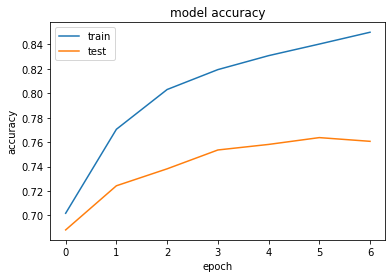

In [27]:
#Accuracy
plt.title('model accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

As we can see, our model achieved train accuracy of around 87% and test accuracy of around 77% which shows that the model is overfitting. 

Testing the Machine Translation model

Let us load the model weights and test our model.

In [30]:
encoder_model = Model(encoder_inputs,encoder_states)

In [32]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [33]:
model.load_weights('seq2seq_eng-fra.h5')

The weights in place it’s time to test our machine translation model by translating a few test sentences.

The inference mode works a bit differently than the training procedure. The procedure can be broken down into 4 steps:

1. Encode the input sequence, return its internal states.

2. Run the decoder using just the start-of-sequence character as input and the encoder internal states as the decoder’s initial states.

3. Append the character predicted (after lookup of the token) by the decoder to the decoded sequence.

4. Repeat the process with the previously predicted character token as input and updates internal states.

Let’s go ahead and implement this. Since we only need the encoder for encoding the input sequence we’ll split the encoder and decoder into two separate models.

In [34]:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

We want our output to be a sequence of words in the French language. To do so, we need to convert the integers back to words. We will create new dictionaries for both inputs and outputs where the keys will be the integers and the corresponding values will be the words.

In [36]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

The method will accept an input-padded sequence English sentence (in the integer form) and will return the translated French sentence.

In [37]:
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

## Predictions

To test the performance we will randomly choose a sentence from the input_sentences list, retrieve the corresponding padded sequence for the sentence, and will pass it to the translate_sentence() method. The method will return the translated sentence.

In [39]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('Input Language : ', input_sentences[i])
print('Actual translation : ', output_sentences[i])
print('French translation : ', translation)

Input Language :  I can't keep it.
Actual translation :  Je ne peux le garder. <eos>
French translation :  je ne peux pas à le faire.


In [40]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('Input Language : ', input_sentences[i])
print('Actual translation : ', output_sentences[i])
print('French translation : ', translation)

Input Language :  I meant no harm.
Actual translation :  Je n'avais pas de mauvaise intention. <eos>
French translation :  je ne n'ai pas de idée.


In [44]:
i = np.random.choice(len(input_sentences))

input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('Input Language : ', input_sentences[i])
print('Actual translation : ', output_sentences[i])
print('French translation : ', translation)

Input Language :  Everyone's asleep.
Actual translation :  Tout le monde dort. <eos>
French translation :  tout est en train de le mal.


Great! Our NMT model has successfully translated so many sentences into French. we can verify that on Google Translate to compare the predictions.

Of course, not all sentences can be translated correctly. In order to increase the accuracy, even more, you can look for the A**ttention mechanism** and embed them in the encoder-decoder structure.


To conclude,  Neural machine translation(NMT) is a fairly advanced application of natural language processing and involves very complex architecture.

Thisnotebook the way it  explained,  we saw the capabilities of encoder-decoder models combined with LSTM layers for sequence-to-sequence learning. The encoder is an LSTM that encodes input sentences while the decoder decodes the inputs and generates corresponding outputs.

Thanks.